<a target="_blank" href="https://colab.research.google.com/github/jackma-00/house-price-prediction/blob/main/src/notebooks/2_house_price_weekly_feature_pipeline.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
!pip uninstall scikit-learn -y

Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0


In [2]:
!pip install scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 15.7 MB/s eta 0:00:00


In [3]:
!pip uninstall xgboost -y

Found existing installation: xgboost 2.1.3
Uninstalling xgboost-2.1.3:
  Successfully uninstalled xgboost-2.1.3


In [4]:
!pip install xgboost==2.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 4.5 MB/s eta 0:00:00


In [5]:
!pip install hopsworks[python]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.6/258.6 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 640.3/640.3 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Imports

In [1]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import hopsworks
from hopsworks.hsfs.builtin_transformations import label_encoder
from hopsworks import udf
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

import warnings
warnings.filterwarnings("ignore")

e:\Learning\house-price-prediction\housepredenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import mysql.connector
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine

load_dotenv()

df = pd.read_csv(r"E:\Learning\house-price-prediction\src\data_scrapper\properties.csv")

DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")  # Add username
DB_PASS = os.getenv("DB_PASS")  # Add password
DB_HOST = os.getenv("DB_HOST")  # Add host
DB_PORT = os.getenv("DB_PORT", "5432")

connection = None

try: 
    connection = mysql.connector.connect(
        database=DB_NAME,
        user=DB_USER,
        password=DB_PASS,
        host=DB_HOST,
        port=DB_PORT
    )
    print("Database connected successfully")


    cursor = connection.cursor()


    query = """
    CREATE TABLE real_estate_data (
        id INT AUTO_INCREMENT PRIMARY KEY,
        brokered_by FLOAT,
        status VARCHAR(50),
        price FLOAT,
        bed FLOAT,
        bath FLOAT,
        acre_lot FLOAT,
        street FLOAT,
        city VARCHAR(100),
        state VARCHAR(50),
        zip_code FLOAT,
        house_size FLOAT,
        prev_sold_date DATE
    );"""


    cursor.execute(query)
    connection.commit()
    print("Table created successfully!")

    cursor.close()
    connection.close()
    
except mysql.connector.Error as err:
    print(f"Error creating table: {err}")

try:
    # Create SQLAlchemy engine
    connection_string = f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
    engine = create_engine(connection_string)
    
    # Insert data
    df.to_sql('real_estate', con=engine, if_exists='append', index=False)
    print(f"Successfully inserted {len(df)} rows into the database")
    
except Exception as e:
    print(f"Error inserting data: {e}")

Database connected successfully
Table created successfully!
Successfully inserted 1084909 rows into the database


## PostgreSQL Data Fetch

In [27]:
import os
# import psycopg2
import pandas as pd
import mysql.connector
from datetime import datetime, timedelta

def fetch_sales_data(query_date):
    """
    Fetch data from the sale table in the scraping schema.

    Args:
        query_date (str): The date to filter the results by scaping_date.

    Returns:
        list: A list of rows from the table.
    """
    # Load database credentials from environment variables
    DB_NAME = os.getenv("DB_NAME")
    DB_USER = os.getenv("DB_USER")  # Add username
    DB_PASS = os.getenv("DB_PASS")  # Add password
    DB_HOST = os.getenv("DB_HOST")  # Add host
    DB_PORT = os.getenv("DB_PORT")

    connection = None
    try:
        # Establish database connection
        connection = mysql.connector.connect(
            database=DB_NAME,
            user=DB_USER,
            password=DB_PASS,
            host=DB_HOST,
            port=DB_PORT
        )
        print("Database connected successfully")

        # Create a cursor
        cursor = connection.cursor()

        # Define and execute the query
        query = """
        SELECT * FROM real_estate LIMIT 10005 ;
        """

        cursor.execute(query)

        # Fetch and return results
        results = cursor.fetchall()
        return results

    except mysql.connector.Error as e:
        print(f"Database error: {e}")

    finally:
        if connection:
            connection.close()
            print("Database connection closed LIMIT 10005")

if __name__ == "__main__":
    # Example usage
    query_date = (datetime.now().date() - timedelta(days=7)).strftime("%Y-%m-%d")
    query_date = "2024-12-16"
    results = fetch_sales_data(query_date)

    print("Data fetched successfully")


Database connected successfully
Database connection closed LIMIT 10005
Data fetched successfully


In [28]:
results

[(0,
  502,
  92147.0,
  'for_sale',
  110000.0,
  7.0,
  3.0,
  0.09,
  1842706.0,
  'Dorado',
  'Puerto Rico',
  949.0,
  1192.0,
  '2019-06-28'),
 (1,
  2270,
  94933.0,
  'for_sale',
  950000.0,
  5.0,
  4.0,
  0.99,
  1260473.0,
  'Saint Thomas',
  'Virgin Islands',
  802.0,
  5000.0,
  '2013-10-11'),
 (2,
  2277,
  103341.0,
  'for_sale',
  6899000.0,
  4.0,
  6.0,
  0.83,
  17467.0,
  'Saint Thomas',
  'Virgin Islands',
  802.0,
  4600.0,
  '2018-04-05'),
 (3,
  3409,
  21163.0,
  'for_sale',
  525000.0,
  3.0,
  3.0,
  0.45,
  1813270.0,
  'Agawam',
  'Massachusetts',
  1001.0,
  2314.0,
  '2014-06-25'),
 (4,
  3410,
  67455.0,
  'for_sale',
  289900.0,
  3.0,
  2.0,
  0.36,
  1698080.0,
  'Agawam',
  'Massachusetts',
  1001.0,
  1276.0,
  '2012-10-12'),
 (5,
  3416,
  97400.0,
  'for_sale',
  384900.0,
  3.0,
  2.0,
  0.46,
  1244899.0,
  'Agawam',
  'Massachusetts',
  1001.0,
  1476.0,
  '1986-11-20'),
 (6,
  3423,
  33714.0,
  'for_sale',
  199999.0,
  3.0,
  2.0,
  1.76,
  

In [29]:
# last_date = results['scraping_date'].max()

# print("The last date is:", last_date)

In [43]:
properties_df = pd.DataFrame(results, columns=df.columns)

In [44]:
properties_df.head()

,Unnamed: 0,index,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,0,502,92147.0,for_sale,110000.0,7.0,3.0,0.09,1842706.0,Dorado,Puerto Rico,949.0,1192.0,2019-06-28
1,1,2270,94933.0,for_sale,950000.0,5.0,4.0,0.99,1260473.0,Saint Thomas,Virgin Islands,802.0,5000.0,2013-10-11
2,2,2277,103341.0,for_sale,6899000.0,4.0,6.0,0.83,17467.0,Saint Thomas,Virgin Islands,802.0,4600.0,2018-04-05
3,3,3409,21163.0,for_sale,525000.0,3.0,3.0,0.45,1813270.0,Agawam,Massachusetts,1001.0,2314.0,2014-06-25
4,4,3410,67455.0,for_sale,289900.0,3.0,2.0,0.36,1698080.0,Agawam,Massachusetts,1001.0,1276.0,2012-10-12


In [48]:
properties_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10005 entries, 0 to 10004
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      10005 non-null  int64  
 1   index           10005 non-null  int64  
 2   brokered_by     10005 non-null  float64
 3   status          10005 non-null  object 
 4   price           10005 non-null  float64
 5   bed             10005 non-null  float64
 6   bath            10005 non-null  float64
 7   acre_lot        10005 non-null  float64
 8   street          10005 non-null  float64
 9   city            10005 non-null  object 
 10  state           10005 non-null  object 
 11  zip_code        10005 non-null  float64
 12  house_size      10005 non-null  float64
 13  prev_sold_date  10005 non-null  object 
dtypes: float64(8), int64(2), object(4)
memory usage: 1.1+ MB


## Connect to Hopsworks Feature Store

In [37]:
# If you haven't set the env variable 'HOPSWORKS_API_KEY', then uncomment the next line and enter your API key
# os.environ["HOPSWORKS_API_KEY"] = ""
proj = hopsworks.login()
fs = proj.get_feature_store()
mr = proj.get_model_registry()
ms = proj.get_model_serving()

2025-04-15 21:59:41,883 INFO: Initializing external client
2025-04-15 21:59:41,884 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-04-15 21:59:44,605 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1222838


## Save new data to feature store

In [50]:
def preprocess_properties_data(properties_df):
    """
    Preprocess the properties DataFrame.

    Args:
        properties_df (pd.DataFrame): Raw properties data.

    Returns:
        pd.DataFrame: Preprocessed properties DataFrame.
    """

    # Convert column names to lowercase
    properties_df.columns = properties_df.columns.str.lower()
    

    # Rename column 'comuneid' to 'codcom'
    # properties_df.rename(columns={"comuneid": "codcom"}, inplace=True)

    # Select relevant columns
    selected_columns = [
        'brokered_by', 'status', 'price', 'bed', 'bath',
       'acre_lot', 'street', 'city', 'state', 'zip_code', 'house_size',
       'prev_sold_date']

    properties_df = properties_df[selected_columns]

    # Drop missing values
    properties_df.dropna(inplace=True)

    # # Convert boolean features to integers
    # boolean_columns = ["isluxury", "isnew", "on_the_market", "zeroenergybuilding"]
    # properties_df[boolean_columns] = properties_df[boolean_columns].astype(int)

    # # Convert codcom from bigint to double
    # properties_df["codcom"] = properties_df["codcom"].astype(float)

    # Parse and sort by scraping_date
    properties_df["prev_sold_date"] = pd.to_datetime(properties_df["prev_sold_date"])
    # properties_df.sort_values(by="scraping_date", inplace=True)

    return properties_df

new_data = preprocess_properties_data(properties_df)

In [51]:
new_data

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,92147.0,for_sale,110000.0,7.0,3.0,0.09,1842706.0,Dorado,Puerto Rico,949.0,1192.0,2019-06-28
1,94933.0,for_sale,950000.0,5.0,4.0,0.99,1260473.0,Saint Thomas,Virgin Islands,802.0,5000.0,2013-10-11
2,103341.0,for_sale,6899000.0,4.0,6.0,0.83,17467.0,Saint Thomas,Virgin Islands,802.0,4600.0,2018-04-05
3,21163.0,for_sale,525000.0,3.0,3.0,0.45,1813270.0,Agawam,Massachusetts,1001.0,2314.0,2014-06-25
4,67455.0,for_sale,289900.0,3.0,2.0,0.36,1698080.0,Agawam,Massachusetts,1001.0,1276.0,2012-10-12
...,...,...,...,...,...,...,...,...,...,...,...,...
10000,81468.0,for_sale,85000.0,4.0,2.0,0.10,794909.0,New London,Connecticut,6320.0,1920.0,1999-03-31
10001,80750.0,for_sale,269900.0,3.0,3.0,0.20,1005719.0,New London,Connecticut,6320.0,1879.0,2008-08-11
10002,10588.0,for_sale,200000.0,3.0,1.0,0.34,481507.0,Norwich,Connecticut,6360.0,1092.0,2002-07-19
10003,75057.0,for_sale,324900.0,3.0,3.0,0.35,1801240.0,Montville,Connecticut,6370.0,1344.0,2002-01-30


In [18]:
def save_to_feature_store(fs, properties_df):
    """
    Save the properties DataFrame to the feature store.

    Args:
        fs: Feature store object.
        properties_df (pd.DataFrame): Preprocessed properties data.
    """
    properties_fg = fs.get_or_create_feature_group(
        name="properties",
        version=4,
        description="Property Features and Corresponding Prices",
        online_enabled=True,
        primary_key=["id"],
        event_time="scraping_date",
    )
    properties_fg.insert(
        properties_df, wait=True
    )  # Wait for data materialization to finish before returning


save_to_feature_store(fs, new_data)

Uploading Dataframe: 100.00% |██████████| Rows 27/27 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: properties_4_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1158295/jobs/named/properties_4_offline_fg_materialization/executions


## Get feature view and latest data

In [74]:
fg = fs.get_feature_group(name="properties", version=4 )
query = fg.select_all()

In [77]:
query

In [80]:
feature_view = fs.get_or_create_feature_view(
    name="house_price_fv", 
    version=5,
    description="house prediction Features groups",
    query=query,
    labels=["price"])

In [82]:
feature_view.get_batch_data()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (76.76s) 


,index,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,1591439,51728.0,sold,149000.0,3.0,1.0,0.18,747999.0,Verona,Virginia,24482.0,1075.0,2022-04-12 00:00:00+00:00
1,1668995,23051.0,sold,215900.0,3.0,2.0,1.14,781753.0,Middleburg,Florida,32068.0,1620.0,2022-02-18 00:00:00+00:00
2,1797046,78435.0,sold,115000.0,3.0,1.0,0.16,1595286.0,Newton,Iowa,50208.0,816.0,2021-11-19 00:00:00+00:00
3,620766,31004.0,for_sale,350000.0,3.0,2.0,0.50,390283.0,Madisonville,Tennessee,37354.0,1806.0,2020-04-30 00:00:00+00:00
4,1990270,57317.0,sold,120000.0,3.0,1.0,0.16,335759.0,Portland,Texas,78374.0,960.0,2021-11-30 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084904,1885526,10710.0,sold,79900.0,3.0,1.0,0.26,347910.0,Cape Girardeau,Missouri,63701.0,864.0,2022-03-25 00:00:00+00:00
1084905,1968427,49338.0,sold,249900.0,2.0,2.0,0.12,14531.0,Conroe,Texas,77384.0,1619.0,2021-11-19 00:00:00+00:00
1084906,1740453,98837.0,sold,117000.0,2.0,2.0,0.30,1132730.0,Inverness,Florida,34453.0,844.0,2022-03-07 00:00:00+00:00
1084907,2061322,42203.0,sold,800000.0,3.0,2.0,0.40,1819672.0,Sunland,California,91040.0,1662.0,2022-04-15 00:00:00+00:00


2025-04-15 22:45:39,480 ERROR: Task exception was never retrieved
future: <Task finished name='Task-7' coro=<AsyncTaskThread.execute_task() done, defined at e:\Learning\house-price-prediction\housepredenv\lib\site-packages\hopsworks_common\util.py:819> exception=OperationalError(2013, 'Lost connection to MySQL server during query')>
Traceback (most recent call last):
  File "e:\Learning\house-price-prediction\housepredenv\lib\site-packages\aiomysql\connection.py", line 657, in _read_bytes
    data = await self._reader.readexactly(num_bytes)
  File "e:\Learning\house-price-prediction\housepredenv\lib\asyncio\streams.py", line 706, in readexactly
    raise exceptions.IncompleteReadError(incomplete, n)
asyncio.exceptions.IncompleteReadError: 0 bytes read on a total of 4 expected bytes

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "e:\Learning\house-price-prediction\housepredenv\lib\site-packages\hopsworks_common\util.py", 

OperationalError: (2013, 'Lost connection to MySQL server during query')

In [83]:
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_size=TEST_SIZE,
    description='house price training dataset',
)

Error: Reading data from Hopsworks, using Hopsworks Feature Query Service           


KeyboardInterrupt: 

## Retrain the model

In [ ]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "house_price_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [ ]:
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8, 10],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [0, 1, 5],
    'reg_alpha': [0, 1, 5]
}

random_search = RandomizedSearchCV(
    estimator=XGBRegressor(),
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    scoring='r2',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 1.0, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 300, 'min_child_weight': 10, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}


In [ ]:
# Predicting target values on the test set
y_pred = best_model.predict(X_test)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 26982919338.538036
R squared: 0.8276609982020513


In [ ]:
df = y_test
df['predicted_price'] = y_pred
df = df.sort_values(by="price").reset_index(drop=True)
df.head(5)

,price,predicted_price
0,35000.0,72810.023438
1,47000.0,63266.773438
2,55000.0,76646.437500
3,55000.0,56229.046875
4,56000.0,97052.515625


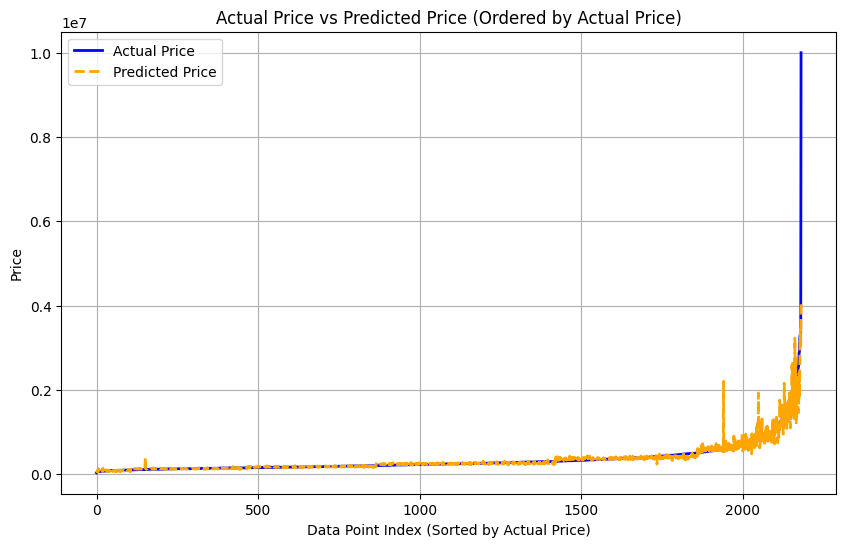

In [ ]:
# Plot
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(df.index, df["price"], label="Actual Price", color='blue', linewidth=2)
plt.plot(df.index, df["predicted_price"], label="Predicted Price", color='orange', linestyle='--', linewidth=2)

# Labels, Title, and Legend
plt.xlabel("Data Point Index (Sorted by Actual Price)")
plt.ylabel("Price")
plt.title("Actual Price vs Predicted Price (Ordered by Actual Price)")
plt.legend()

# Grid
plt.grid(True)

# Save the plot to the desired file path
os.makedirs(images_dir, exist_ok=True)  # Create the directory if it doesn't exist
file_path = images_dir + "/price_hindcast.png"
plt.savefig(file_path, format='png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

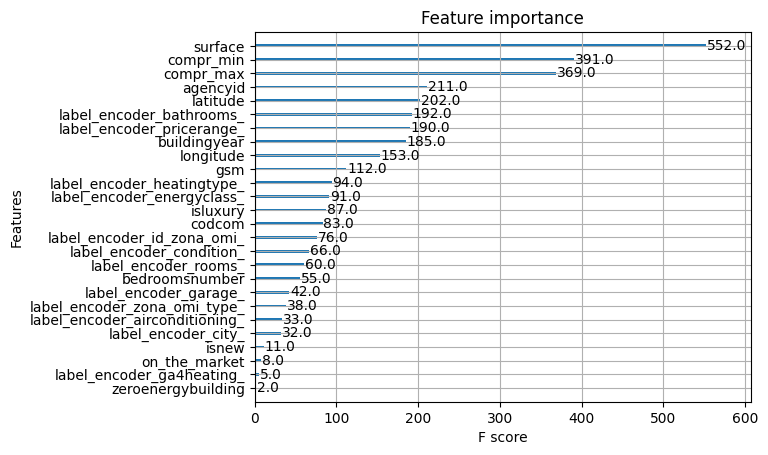

In [ ]:
plot_importance(best_model, importance_type='weight')
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

## Update Model Registry

In [ ]:
# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [ ]:
# Saving the XGBoost regressor object as a json file in the model directory
best_model.save_model(model_dir + "/model.json")

In [ ]:
res_dict = {
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [ ]:
hp_model = mr.python.create_model(
    name="house_price_xgboost_model",
    metrics=res_dict,
    feature_view=feature_view,                    # Add a feature view to the model
    model_schema=model_schema,
    input_example=X_test.sample().values,
    description="Italian house price predictor",
)

# Saving the model artifacts to the 'house_price_model' directory in the model registry
hp_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/465401 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/145436 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/61439 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/173 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/2379 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1158295/models/house_price_xgboost_model/18


Model(name: 'house_price_xgboost_model', version: 18)

## Create new deployment

In [ ]:
retrieved_models = mr.get_models("house_price_xgboost_model")
retrieved_models

[Model(name: 'house_price_xgboost_model', version: 13),
 Model(name: 'house_price_xgboost_model', version: 18),
 Model(name: 'house_price_xgboost_model', version: 8),
 Model(name: 'house_price_xgboost_model', version: 14),
 Model(name: 'house_price_xgboost_model', version: 15),
 Model(name: 'house_price_xgboost_model', version: 16),
 Model(name: 'house_price_xgboost_model', version: 1)]

In [ ]:
# Get latest version
sorted_models = sorted(retrieved_models, key=lambda x: x.version)
latest_model = sorted_models[-1]
latest_model

Model(name: 'house_price_xgboost_model', version: 18)

In [ ]:
deployment = ms.get_deployment("house")

In [ ]:
# Delete the old deployment
deployment.delete(force=True)

Deployment deleted successfully


In [ ]:
predictor_script_path = os.path.join("/Projects", proj.name, "Models", "predict_house_price.py")
predictor_script_path

'/Projects/id2223_group_17_labs/Models/predict_house_price.py'

In [ ]:
# Deploy the new model
deployment = latest_model.deploy(
    name="house",                 # Specify the deployment name
    script_file=predictor_script_path,  # Provide the path to the predictor script
)

Deployment created, explore it at https://c.app.hopsworks.ai:443/p/1158295/deployments/352270
Before making predictions, start the deployment by using `.start()`


In [ ]:
# Start the deployment and wait for it to be running, with a maximum waiting time of 180 seconds
deployment.start(await_running=180)

  0%|          | 0/5 [00:00<?, ?it/s]

Start making predictions by using `.predict()`
